## Model discovery for PDE

In this notebook we use the DeepMoD algorithm applied on the the PDE of an EWH. This version is just a test on the simulation datas. A final version will be developped when we have access to test bench again.

We start by importing the required DeepMoD functions:

In [104]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions


from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if False: #torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


Before we send the data into the Dataset format, create a plot to get an idea of the data:


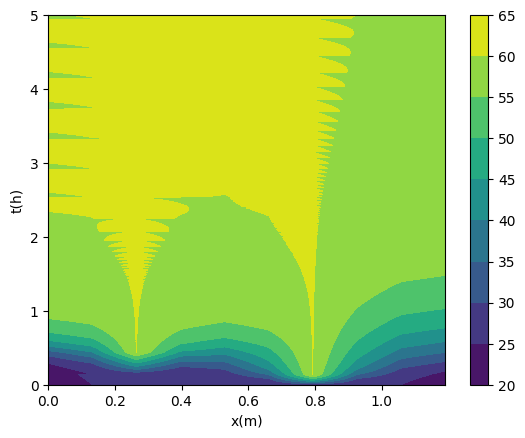

In [105]:
data = np.load('EWH_sim_NullFlow_CN_data.npy', allow_pickle=True).item()
fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t']/3600, np.real(data['u']))
ax.set_xlabel('x(m)')
ax.set_ylabel('t(h)')
fig.colorbar(mappable=im)

plt.show()

We can now define a function that loads the data, makes torch tensors out of it and then returns it in a coords, data format. The shape of the samples will be (t,x) for the input and (u) for the dataset. Ensure that any array is not 1D, so an array with a single feature can be the shape (N,1) using reshape(-1,1) in numpy or unsqueeze(-1) in torch.

In [106]:
def load_data():
    array = np.load('EWH_sim_NullFlow_CN_data.npy', allow_pickle=True).item()
    coords = torch.from_numpy(np.stack((array["t"],array["x"],array["Q"]), axis=-1)).float()
    data = torch.from_numpy(np.real(array["u"])).unsqueeze(-1).float()
    return coords, data

First of all, We'll create a subclasse of Dataset(a custum version of the classe) which have Q and V as extra arguments

We can now pass the function that loads the data to the DeePyMoD Dataset module, which loads the data, preprocesses it, subsamples it and then sends it to the right device.

In [107]:

# V = torch.from_numpy(np.real(data["V"])).unsqueeze(-1).float()

dataset = Dataset(
    load_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 5000},
    device=device,
)

Dataset is using device:  cpu


Now we need to split our data into a train and test dataloaders for PyTorch

In [108]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

# Setup a custom library

In this cell we'll create a custom build library.The library function, $\theta$, in this case contains $[1,u,u_x, u_xx, V*u_x, Q]$ . But how to insert Q and V in our dataset. We could think about a subclass of dataset where we'll add some extra arguments Huuuuuuuuuuuuuuuum.🤔🤔🤔

In [109]:
from torch.autograd import grad
from itertools import combinations, product
from functools import reduce
from deepymod.model.library import library_poly, library_deriv

In [110]:


class Library_EWH(Library):
    """[summary]

    Args:
        Library ([type]): [description]
    """

    def __init__(self, poly_order: int = 1) -> None:
        """Calculates the temporal derivative a library/feature matrix consisting of
        1) polynomials up to order poly_order, i.e. u, u^2...
        2) derivatives up to order diff_order, i.e. u_x, u_xx
        3) cross terms of 1) and 2), i.e. $uu_x$, $u^2u_xx$

        Order of terms is derivative first, i.e. [$1, u_x, u, uu_x, u^2, ...$]

        Only works for 1D+1 data. Also works for multiple outputs but in that case doesn't calculate
        polynomial and derivative cross terms.

        Args:
            poly_order (int): maximum order of the polynomial in the library
            diff_order (int): maximum order of the differentials in the library
        """

        super().__init__()
        self.poly_order = poly_order
        # self.diff_order = diff_order

    def library(
        self, input: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[TensorList, TensorList]:
        """Compute a 2D library up to given polynomial order with second order derivatives
         i.e. for poly_order=1: [$1, u_x, u_Q, u_{xx}, u_{QQ}, u_{xQ}, Q$] because is considered as an input of our neural network

        Args:
            input (Tuple[torch.Tensor, torch.Tensor]): A prediction u (n_samples, n_outputs) and spatiotemporal locations (n_samples, 3).(Q is the thrid input)

        Returns:
            Tuple[TensorList, TensorList]: The time derivatives and the thetas
            computed from the library and data.
        """
        prediction, data = input
        # Polynomial

        u = torch.ones_like(prediction)
        for order in np.arange(1, self.poly_order + 1):
            u = torch.cat((u, u[:, order - 1 : order] * prediction), dim=1)

        # Gradients
        du = grad(
            prediction,
            data,
            grad_outputs=torch.ones_like(prediction),
            create_graph=True,
        )[0]
        u_t = du[:, 0:1]
        u_x = du[:, 1:2]
        u_Q = du[:, 2:3]
        du2 = grad(
            u_x, data, grad_outputs=torch.ones_like(prediction), create_graph=True
        )[0]
        u_xx = du2[:, 1:2]
        u_xQ = du2[:, 2:3]
        u_QQ = grad(
            u_Q, data, grad_outputs=torch.ones_like(prediction), create_graph=True
        )[0][:, 2:3]

        du = torch.cat((torch.ones_like(u_x), u_x, u_Q, u_xx, u_QQ, u_xQ), dim=1)

        samples = du.shape[0]
        # Bringing it together
        theta = torch.matmul(u[:, :, None], du[:, None, :]).view(samples, -1)
        theta = torch.cat((theta, data[:, 2:3]), dim=1) #We add Q in the library, at the end of theta
        return [u_t], [theta]


## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [111]:
network = NN(3, [50, 50, 50, 50], 1)

Configuration of the library function: We select the custom build library we created earlier
* [$1, u_x, u_{Q}, u_{xx}, u_{QQ}, u_{xQ}, u, uu_x, uu_{Q}, uu_{xx}, uu_{QQ}, uu_{xQ},  Q$] (with poly order = 2)

In [112]:
library = Library_EWH(poly_order=2)

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-8, the algorithm is converged.

In [113]:
estimator = Threshold(1e-8)
sparsity_scheduler = TrainTestPeriodic()

Configuration of the sparsity estimator

In [114]:
constraint = LeastSquares()

Now, we instantiate the model and select the optimizer

In [115]:
model = DeepMoD(network, library, estimator, constraint).to(device)

Defining optimizer

In [116]:
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-5
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [117]:
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir="/data/deepymod/coupled_new/",
    max_iterations=100000,
    delta=1e-2,
    patience=200
)

 99975  MSE: 4.36e+02  Reg: 3.05e-12  L1: 1.60e+04 Algorithm converged. Writing model to disk.


Now that DeepMoD has converged, it has found the following coefficients to not be zero: 

In [118]:
model.sparsity_masks

[tensor([True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True])]

And it found the following coefficients.

In [119]:
model.estimator_coeffs()

[array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.6928086 ],
        [-0.30635703],
        [ 0.        ],
        [ 0.        ],
        [ 0.04446565],
        [ 0.        ],
        [ 0.        ],
        [-0.04373562],
        [ 0.        ],
        [ 0.        ],
        [ 0.04335818],
        [ 0.        ],
        [ 0.        ],
        [-0.04263895],
        [ 0.        ],
        [ 0.        ]], dtype=float32)]

Then the absolute value of the coefficients